In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# data

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)

air_pressure = new_data[['AIR_PRESSURE']]
print(air_pressure)

# count the NaN values
nan_count_air_pressure = air_pressure['AIR_PRESSURE'].isna().sum()
print(nan_count_air_pressure)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=air_pressure.index.min(), end=air_pressure.index.max(), freq='5T')
missing_timestamps = complete_range.difference(air_pressure.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
air_pressure_incomplete = df_complete_range.merge(air_pressure, left_index=True, right_index=True, how='left')
# print(air_pressure_incomplete)
air_pressure_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
air_pressure_all = air_pressure_incomplete.bfill()
print(air_pressure_all)
air_pressure_all.isna().sum() # okay

str(air_pressure_all.index.dtype) # okay

parameter_type             AIR_PRESSURE
acquisition_timestamp                  
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-05-31 21:55:00+00:00         964.9

[271508 rows x 1 columns]
0
5112
                           AIR_PRESSURE
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-0

'datetime64[ns, UTC]'

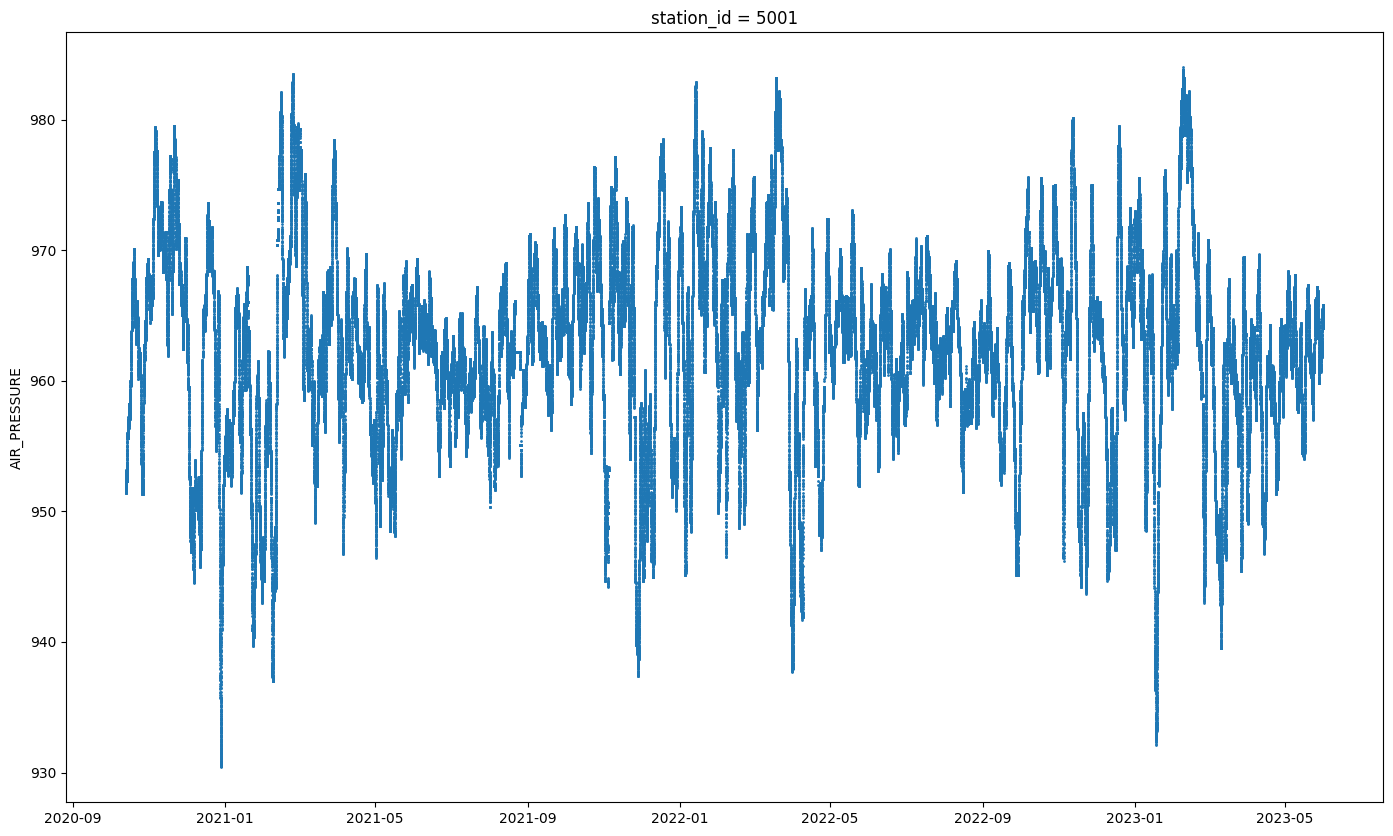

In [3]:
# plot 'AIR_PRESSURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(air_pressure_all.index, air_pressure_all['AIR_PRESSURE'],s=1)
ax.set_ylabel('AIR_PRESSURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

In [4]:
air_pressure_20_21 = air_pressure_all.loc[(air_pressure_all.index.year == 2020) | (air_pressure_all.index.year == 2021) , 'AIR_PRESSURE']
print(air_pressure_20_21)

2020-10-13 10:20:00+00:00    952.8
2020-10-13 10:25:00+00:00    952.8
2020-10-13 10:30:00+00:00    952.8
2020-10-13 10:35:00+00:00    952.8
2020-10-13 10:40:00+00:00    952.8
                             ...  
2021-12-31 23:35:00+00:00    968.9
2021-12-31 23:40:00+00:00    968.8
2021-12-31 23:45:00+00:00    968.9
2021-12-31 23:50:00+00:00    968.9
2021-12-31 23:55:00+00:00    969.0
Freq: 5T, Name: AIR_PRESSURE, Length: 128036, dtype: float64


In [18]:
# hourly data
# sum the values for each hour and take the mean

str(air_pressure_20_21.index.dtype) # okay
air_pressure_20_21_hourly = air_pressure_20_21.resample('H').mean()
print(air_pressure_20_21_hourly)

2020-10-13 10:00:00+00:00    952.762500
2020-10-13 11:00:00+00:00    952.366667
2020-10-13 12:00:00+00:00    951.783333
2020-10-13 13:00:00+00:00    951.691667
2020-10-13 14:00:00+00:00    951.508333
                                ...    
2021-12-31 19:00:00+00:00    968.233333
2021-12-31 20:00:00+00:00    968.583333
2021-12-31 21:00:00+00:00    969.258333
2021-12-31 22:00:00+00:00    969.966667
2021-12-31 23:00:00+00:00    969.058333
Freq: H, Name: AIR_PRESSURE, Length: 10670, dtype: float64


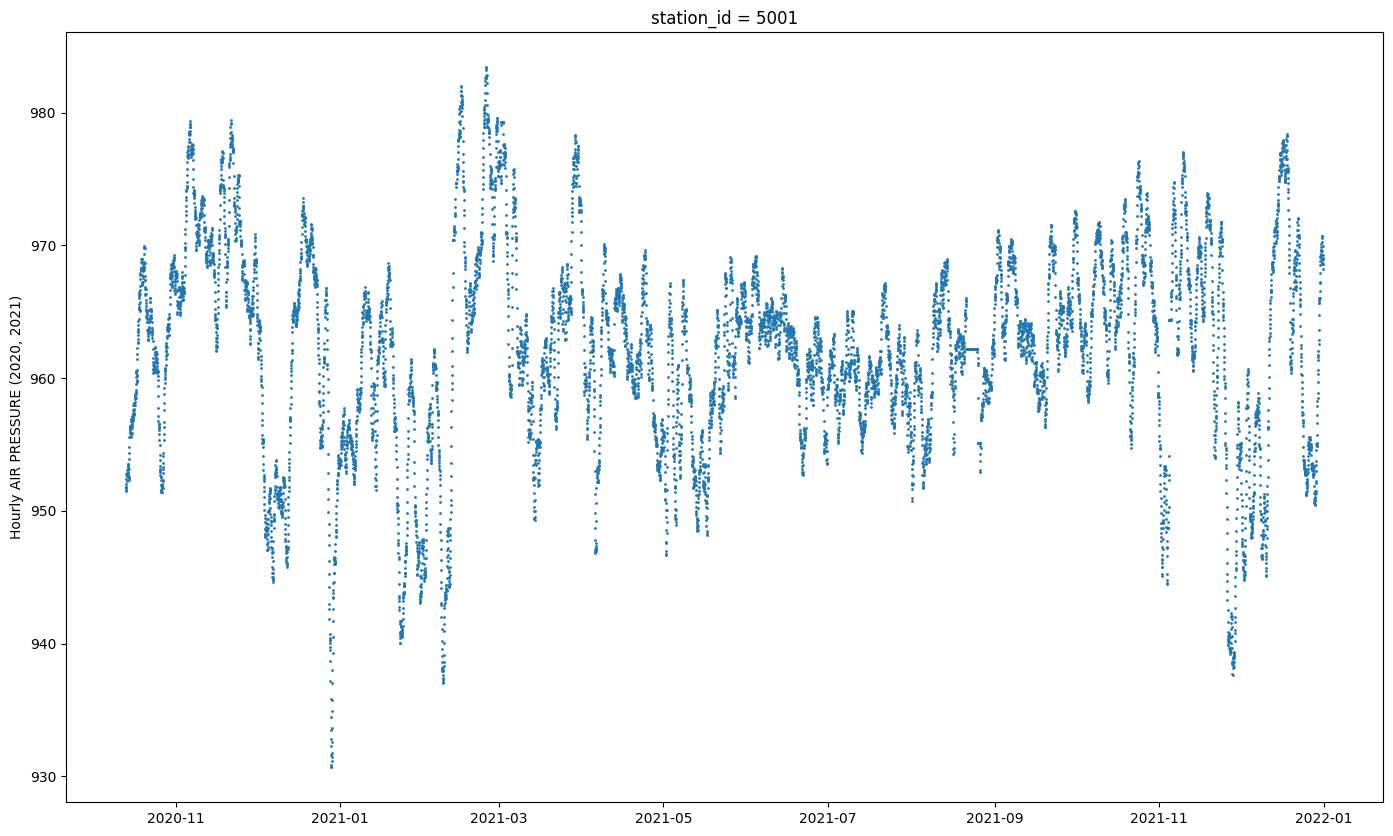

In [19]:
# plot hourly 'AIR_PRESSURE' for 2020 and 2021
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(air_pressure_20_21_hourly.index, air_pressure_20_21_hourly, s=1)
ax.set_ylabel('Hourly AIR PRESSURE (2020, 2021)')
ax.set_title(f'station_id = {station_id}')  
plt.show()

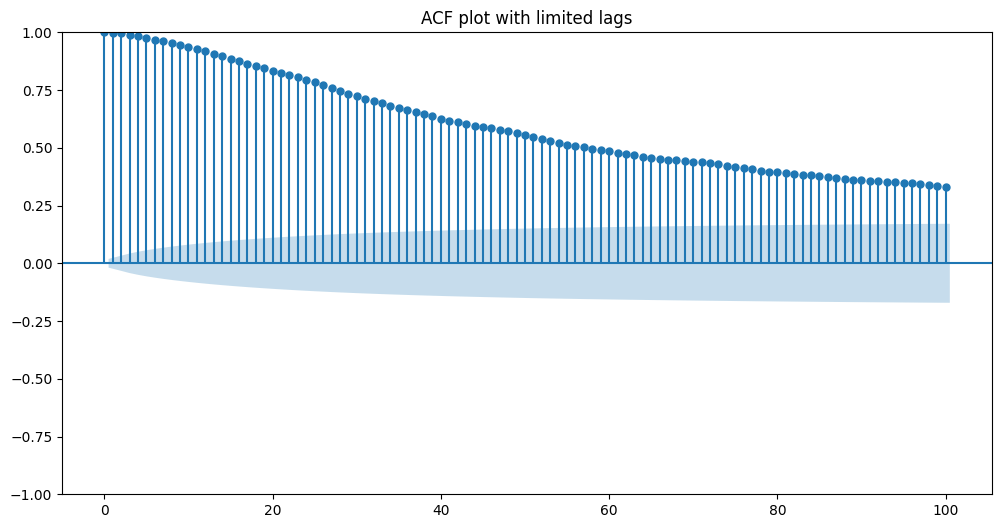

In [30]:
import matplotlib.pyplot as pyplot
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF with a limited number of lags
fig, ax = pyplot.subplots(figsize=(12, 6))
plot_acf(air_pressure_20_21_hourly, lags=100, ax=ax)  # Limit the number of lags to 50
pyplot.title('ACF plot with limited lags')
pyplot.show()

In [13]:
# ARIMA for 2020 and 2021
from pmdarima import auto_arima
stepwise_fit = auto_arima(air_pressure_20_21_hourly, trace=True,
suppress_warnings=True)
# it takes around 4 min- way less than when having 5 minute intervals (95 min)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4262.721, Time=10.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11814.267, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4326.163, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6848.241, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11812.408, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4310.516, Time=3.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4312.803, Time=1.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4183.886, Time=17.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4280.023, Time=6.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4137.232, Time=8.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4143.464, Time=6.26 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4093.088, Time=22.94 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4127.570, Time=21.35 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3983.868, Time=31.30 sec
 ARIMA(4,1,3)(0,0,0)[0] in

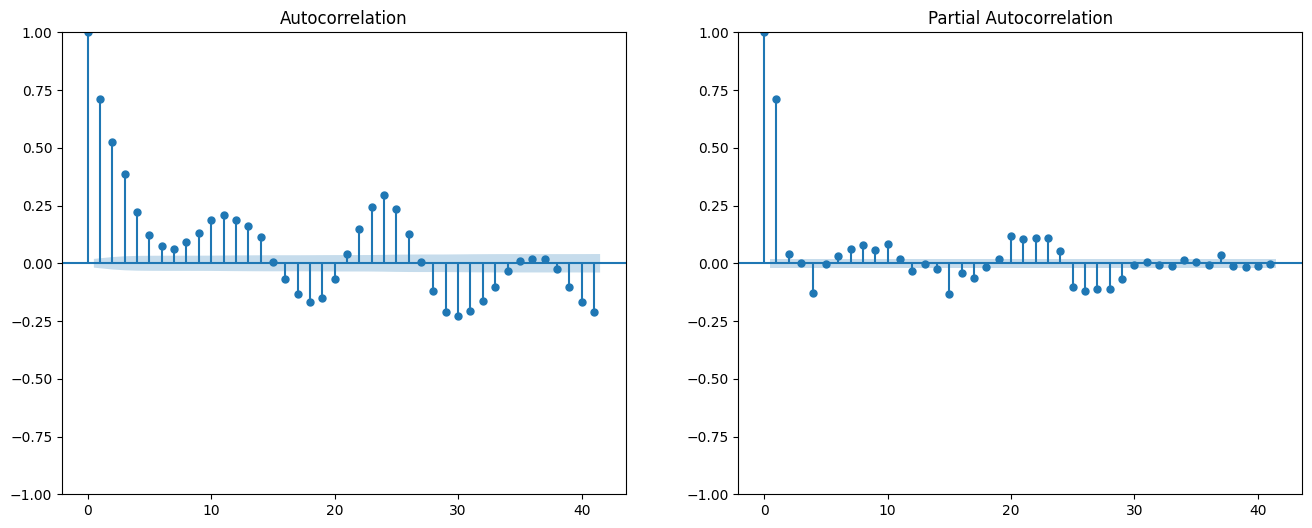

                               SARIMAX Results                                
Dep. Variable:           AIR_PRESSURE   No. Observations:                10670
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2125.370
Date:                Thu, 16 May 2024   AIC                           4260.740
Time:                        18:29:23   BIC                           4297.115
Sample:                    10-13-2020   HQIC                          4273.013
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2773      0.078     16.439      0.000       1.125       1.430
ar.L2         -0.4442      0.057     -7.753      0.000      -0.557      -0.332
ma.L1         -0.6125      0.078     -7.869      0.0

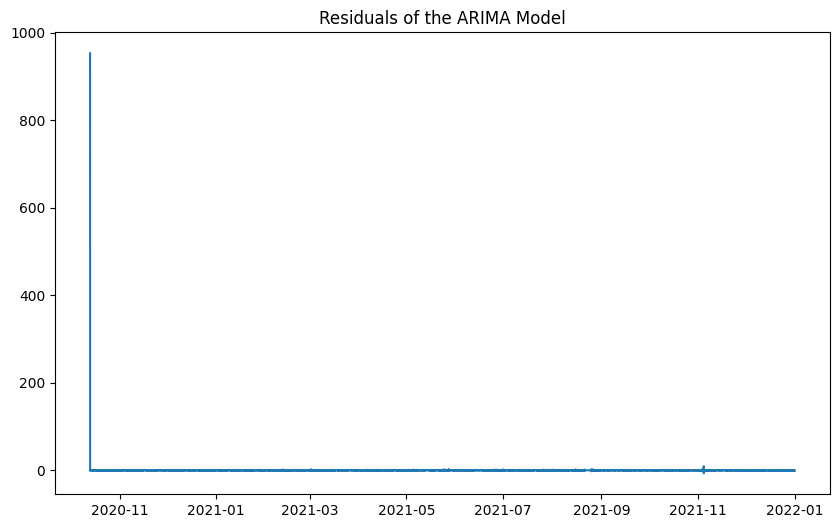

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# differencing
air_pressure_diff = air_pressure_20_21_hourly.diff().dropna()

# plot ACF and PACF to determine appropriate ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(air_pressure_diff, ax=ax[0])
plot_pacf(air_pressure_diff, ax=ax[1])
plt.show()

# fit the ARIMA model
model_air_pressure_20_21_hourly = ARIMA(air_pressure_20_21_hourly, order=(2,1,2))
fit = model_air_pressure_20_21_hourly.fit()

# summary of the model
print(fit.summary())

# residuals
residuals_air_pressure_20_21_hourly = fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_air_pressure_20_21_hourly)
plt.title('Residuals of the ARIMA Model')
plt.show()

In [14]:
# sum the values for each hour and take the mean

str(air_pressure_all.index.dtype) # okay
air_pressure_all_hourly = air_pressure_all.resample('H').mean()
print(air_pressure_all_hourly)

                           AIR_PRESSURE
2020-10-13 10:00:00+00:00    952.762500
2020-10-13 11:00:00+00:00    952.366667
2020-10-13 12:00:00+00:00    951.783333
2020-10-13 13:00:00+00:00    951.691667
2020-10-13 14:00:00+00:00    951.508333
...                                 ...
2023-05-31 17:00:00+00:00    964.141667
2023-05-31 18:00:00+00:00    964.275000
2023-05-31 19:00:00+00:00    964.991667
2023-05-31 20:00:00+00:00    965.066667
2023-05-31 21:00:00+00:00    964.900000

[23052 rows x 1 columns]


In [16]:
# ARIMA for all the hourly air pressure data
from pmdarima import auto_arima
stepwise_fit = auto_arima(air_pressure_all_hourly, trace=True,
suppress_warnings=True)
# it takes around 5 min

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8153.709, Time=7.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=159548.143, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128344.313, Time=5.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382134.307, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=11221.567, Time=4.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8154.259, Time=3.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8374.295, Time=29.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7833.095, Time=10.51 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9134.196, Time=5.33 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7775.118, Time=26.42 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=7781.580, Time=32.36 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8971.288, Time=39.42 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=7808.244, Time=12.88 sec
 ARIMA(4,0,2)(0,0,0)[0] i

Best model for hourly data for 2020 and 2021 is ARIMA(5,1,2).

Best model for all hourly data is ARIMA(3,0,3).

Best model for for data in 5 minute intervals in 2020 and 2021 is ARIMA(3,1,1).

In [ ]:
# fitting the model

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(air_pressure_20_21, order=(2,1,3))
fit = model.fit()

# residuals
residuals = fit.resid

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 15)
d = range(0, 5)
q = range(0, 15)

# a list to store the results
results = []

# Perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(air_pressure_20_21_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# Sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# Print the top 5 models
print(results_df.head())

# Choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# Fit the best model
best_model = ARIMA(air_pressure_20_21_hourly, order=best_order)
best_fit = best_model.fit()

# Check the summary of the best model
print(best_fit.summary())

# Residuals of the best model
residuals_best = best_fit.resid

# Plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# Plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()